# Алгоритмы анализа данных

### Урок 6. Градиентный бустинг (AdaBoost)

## <center> Практическое задание </center>

__Задание 1:__ Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

__Задание 2: (опция).__ Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

__Задание 3: (опция).__ Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

## Реализация алгоритма градиентного бустинга (GBM)

Возьмем готовую реализацию дерева решений для регрессии из библиотеки sklearn.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из датасет из sklearn.datasets.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.25
)


 Функцию, реализующая предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # coef_list - коэффициент  𝛾  для найденного алгоритма
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

# 

Основной способ измерить отклонение - посчитать квадрат разности $Q(a,y)=(a(x)-y)^{2}$. Такая функция является гладкой и имеет производную в каждой точке, а ее минимум достигается при равенстве истинного ответа $y$ и прогноза $a(x)$.

Основанный на этой функции <u>функционал ошибки</u> называется ___среднеквадратичным отклонением___ (mean squared error, ___MSE___):

$$Q(a,x) = \frac{1}{l}\sum^{l}_{i=1}(a(x_{i})-y_{i})^{2}.$$


Другой функционал ошибки называется ___средний модуль отклонения___ (mean absolute error, ___MAE___):
$$\displaystyle MAE = \frac{1}{l} \sum_{i=1}^{l}|y_{i}-\hat{y_i}|.$$

В качестве функционала ошибки будем использовать среднеквадратичную ошибку.

In [6]:
# Cреднеквадратичное отклонение (mean squared error, MSE):
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

## 

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    # Производная функции потерь
    
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [26]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """
    Функция обучения градиентного бустинга.

    Parameters
    ----------
    n_trees:
        Количество деревьев?.

    max_depth: int
        Max-я глубина дерева.
        
    X_train, X_test, y_train, y_test,
    
    coefs:
        коэффициенты  𝛾  для алгоритма
    
    eta: int
        Шаг.

    Returns
    -------
    trees: DecisionTreeRegressor
    
    train_errors: float
                
    test_errors: float
    
    """
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)  # A decision tree regressor

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            y_pred = gb_predict(X_train, trees, coefs, eta)
            target = bias(y_train, y_pred)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, target)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

__Регрессор__ - фактор, независимая переменная $x_i$

По умолчанию scikit-learn DecisionTreeRegressor возвращает среднее значение всех целевых значений из набора тренировок в данном листовом узле.

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [11]:
np.mean(y_train), np.mean(y_test)

(153.71601208459214, 147.4144144144144)

In [12]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 948.6241544105945
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5506.027949331994


Построим графики зависимости ошибки на обучающей и тестовой выборках __от числа итераций__.

In [13]:
import matplotlib.pyplot as plt

In [14]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [15]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

𝐿1 -регуляризация также называется Lasso,  𝐿2 -регуляризация иногда называется Ridge.

### 1. Задача:

- Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки:
    - от количества деревьев в ансамбле
    - от максимальной глубины деревьев.
- Сделать выводы о зависимости ошибки от этих параметров.

__1.1__ Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле.

n_trees - Число деревьев в ансамбле<br><br>

Учитывая, что:

test_errors при n_trees = 3:<br>
[26245.162162162163, 4460.878084340738, 4460.69950578709]<br><br>
test_errors при n_trees = 5:<br>
[26245.162162162163, 4460.878084340738, 4460.69950578709, 5011.208153952112, 5269.248536676613]<br><br>
test_errors при n_trees = 10:<br>
[26245.162162162163, 4460.878084340738, 4460.69950578709, 5011.208153952112, 5269.248536676613,<br>
 5272.129182317965, 5523.038370524697, 5506.901730442979, 5619.71525862455, 5661.500288268941]
 
 Видно, что каждая итерация функции  __gb_fit()__, соответствует максимальному числу деревьев в ансамбле, [1,2,3, ..., 10] соответственно.
 
 
 С учётом этого напишем функцию построения графика зависимости ошибки от количества деревьев в ансамбле.

In [16]:
# Graph of error versus number of trees in ensemble
def get_error_plot(n_trees, train_err, test_err):
    # n_trees - Число деревьев в ансамбле
    
    plt.xlabel('Число деревьев в ансамбле')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

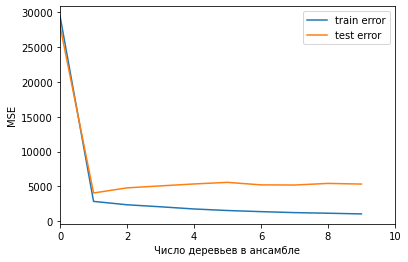

      	 train_errors 		 test_errors
____________________________________________________
шаг 1 | 2846.220580659837 	 4051.2686948392234
шаг 2 | 2360.129106336383 	 4789.12822335856
шаг 3 | 2072.184630606552 	 5072.530685789605


In [17]:
get_error_plot(n_trees, train_errors, test_errors)
print(f'      \t train_errors \t\t test_errors')
print('_'*52)
print('шаг 1 |', train_errors[1], '\t', test_errors[1])
print('шаг 2 |', train_errors[2], '\t', test_errors[2])
print('шаг 3 |', train_errors[3], '\t', test_errors[3])

__Вывод:__

__1.1__
Из графика и значений ошибок видно, что резгий изгиб графика происходит на 1 шаге (число деревьев в ансамбле n_trees = 2), _при постоянных остальных критериях (максимальная глубина деревьев
max_depth = 3, коэффициенты: coefs = 1 и Шаг: eta = 1)_.<br>


       train_errors 	  test_errors
шаг 1 | 2839.667157109237&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 3808.8682065553307<br>
шаг 2 | 2514.1926774245494&nbsp;&nbsp;&nbsp;&nbsp;4066.054971603613<br>
шаг 3 | 2126.795417740424&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 4394.533263486755<br>


Далее при увеличении числа деревьев в ансамбле n_trees (n_trees > 2), ошибка на трейне продолжает уменьшаться, но на тесте начинает расти.

Исходя из этого заключаем, что в данном конкретном случае, при увеличении числа деревьев в ансамбле n_trees > 2, модель переобучается (при заданных, постоянных остальных критериях).

# 

__1.2__ Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от максимальной глубины деревьев.


In [18]:
# Graph of error dependence on maximum tree depth
def get_error_plot(n_trees, train_err, test_err, max_depth):
    label_txt = 'Iteration number\nМаксимальная глубина деревьев=' + str(max_depth)
    plt.xlabel(label_txt)
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [19]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

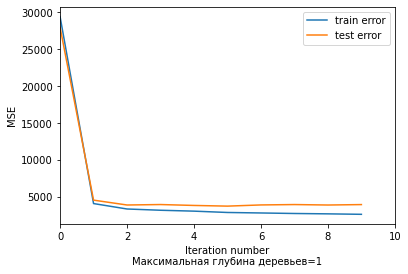

      	 train_errors 		 test_errors
____________________________________________________
шаг 1 | 4085.8793439900014 	 4551.0165694944335
шаг 2 | 3350.2526194906523 	 3891.5541444394635
шаг 3 | 3179.195168648426 	 3954.1075520822387


In [20]:
# Максимальная глубина деревьев
max_depth = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors, max_depth)

print(f'      \t train_errors \t\t test_errors')
print('_'*52)
print('шаг 1 |', train_errors[1], '\t', test_errors[1])
print('шаг 2 |', train_errors[2], '\t', test_errors[2])
print('шаг 3 |', train_errors[3], '\t', test_errors[3])

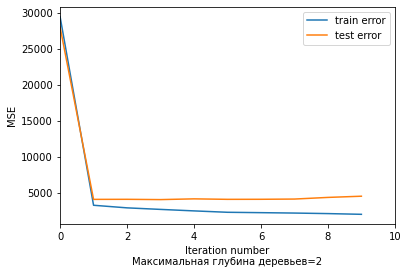

      	 train_errors 		 test_errors
____________________________________________________
шаг 1 | 3244.2984311899595 	 4061.6066718036886
шаг 2 | 2884.5524188880686 	 4070.7741967194893
шаг 3 | 2669.7110734503403 	 4031.0303074206527


In [21]:
# Максимальная глубина деревьев
max_depth = 2

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors, max_depth)

print(f'      \t train_errors \t\t test_errors')
print('_'*52)
print('шаг 1 |', train_errors[1], '\t', test_errors[1])
print('шаг 2 |', train_errors[2], '\t', test_errors[2])
print('шаг 3 |', train_errors[3], '\t', test_errors[3])

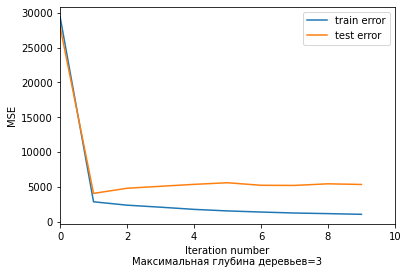

      	 train_errors 		 test_errors
____________________________________________________
шаг 1 | 2846.220580659837 	 4051.2686948392234
шаг 2 | 2360.129106336383 	 4789.12822335856
шаг 3 | 2072.184630606552 	 5072.530685789605


In [22]:
# Максимальная глубина деревьев
max_depth = 3

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors, max_depth)

print(f'      \t train_errors \t\t test_errors')
print('_'*52)
print('шаг 1 |', train_errors[1], '\t', test_errors[1])
print('шаг 2 |', train_errors[2], '\t', test_errors[2])
print('шаг 3 |', train_errors[3], '\t', test_errors[3])

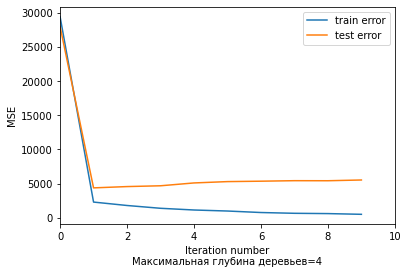

      	 train_errors 		 test_errors
____________________________________________________
шаг 1 | 2285.4099234301975 	 4365.048252908792
шаг 2 | 1785.6284904139147 	 4555.045111065534
шаг 3 | 1375.5767068185048 	 4671.824877022029


In [23]:
# Максимальная глубина деревьев
max_depth = 4

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors, max_depth)

print(f'      \t train_errors \t\t test_errors')
print('_'*52)
print('шаг 1 |', train_errors[1], '\t', test_errors[1])
print('шаг 2 |', train_errors[2], '\t', test_errors[2])
print('шаг 3 |', train_errors[3], '\t', test_errors[3])
# Видно, что модель переобучилась

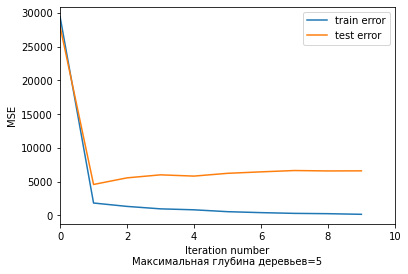

      	 train_errors 		 test_errors
____________________________________________________
шаг 1 | 1837.6265073788115 	 4584.658082521537
шаг 2 | 1335.7803427516828 	 5563.2247409169495
шаг 3 | 973.1423686858967 	 6009.767147933885


In [24]:
# Максимальная глубина деревьев
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors, max_depth)

print(f'      \t train_errors \t\t test_errors')
print('_'*52)
print('шаг 1 |', train_errors[1], '\t', test_errors[1])
print('шаг 2 |', train_errors[2], '\t', test_errors[2])
print('шаг 3 |', train_errors[3], '\t', test_errors[3])
# Видно, что модель переобучилась

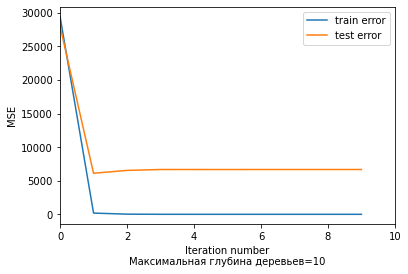

      	 train_errors 		 test_errors
____________________________________________________
шаг 1 | 181.95466627738708 	 6113.801960988778
шаг 2 | 24.023115787459254 	 6539.79197243685
шаг 3 | 1.7836042256714795 	 6672.675465452565


In [25]:
# Максимальная глубина деревьев
max_depth = 10

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors, max_depth)

print(f'      \t train_errors \t\t test_errors')
print('_'*52)
print('шаг 1 |', train_errors[1], '\t', test_errors[1])
print('шаг 2 |', train_errors[2], '\t', test_errors[2])
print('шаг 3 |', train_errors[3], '\t', test_errors[3])
# Видно, что модель переобучилась

__Вывод:__

1.2 
Из графиков и значений ошибок видно, что оптимальным значением глубины дерева, _при постоянных остальных критериях (Число деревьев в ансамбле: n_trees = 10, 
коэффициенты: coefs = 1 и Шаг: eta = 1)_, является __max_depth = 3__.

       train_errors 	  test_errors
шаг 1 | 2839.667157109237&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 3808.8682065553307<br>
шаг 2 | 2514.1926774245494&nbsp;&nbsp;&nbsp;&nbsp;4066.054971603613<br>
шаг 3 | 2126.795417740424&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 4394.533263486755<br>

С увеличением максимальной глубина деревьев max_depth (max_depth > 3) ошибка на трейне уменьшает, но на тесте начинает расти.<br>
Исходя из этого заключаем, что при max_depth > 3 модель переобучается.

# 
__1.3__ Сделать выводы о зависимости ошибки от этих параметров.

__Выводы:__

__1.1__
Из графика и значений ошибок видно, что резгий изгиб графика происходит на 1 шаге (число деревьев в ансамбле n_trees = 2), _при постоянных остальных критериях (максимальная глубина деревьев
max_depth = 3, коэффициенты: coefs = 1 и Шаг: eta = 1)_.<br>

       train_errors 	  test_errors
шаг 1 | 2839.667157109237&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 3808.8682065553307<br>
шаг 2 | 2514.1926774245494&nbsp;&nbsp;&nbsp;&nbsp;4066.054971603613<br>
шаг 3 | 2126.795417740424&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 4394.533263486755<br>

Далее при увеличении числа деревьев в ансамбле n_trees (n_trees > 2), ошибка на трейне продолжает уменьшаться, но на тесте начинает расти.

Исходя из этого заключаем, что в данном конкретном случае, при увеличении числа деревьев в ансамбле n_trees > 2, модель переобучается (при заданных, постоянных остальных критериях).    
    
__1.2__
Из графиков и значений ошибок видно, что оптимальным значением глубины дерева, _при постоянных остальных критериях (Число деревьев в ансамбле: n_trees = 10, 
коэффициенты: coefs = 1 и Шаг: eta = 1)_, является __max_depth = 3__.

       train_errors 	  test_errors
шаг 1 | 2839.667157109237&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 3808.8682065553307<br>
шаг 2 | 2514.1926774245494&nbsp;&nbsp;&nbsp;&nbsp;4066.054971603613<br>
шаг 3 | 2126.795417740424&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 	 4394.533263486755<br>

С увеличением максимальной глубина деревьев max_depth (max_depth > 3) ошибка на трейне уменьшает, но на тесте начинает расти.<br>
Исходя из этого заключаем, что при max_depth > 3 модель переобучается.